In [168]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

In [169]:
df = pd.read_csv(r'C:\Users\ashbat\Desktop\totalByWeekWHTomatoes.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'W-MON'

In [170]:
df.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,292.85886,0
2016-03-21,528.13998,39
2016-03-28,586.91094,0
2016-04-04,474.18022,0
2016-04-11,491.09386,0


In [171]:
print(df.index.freq)

<Week: weekday=0>


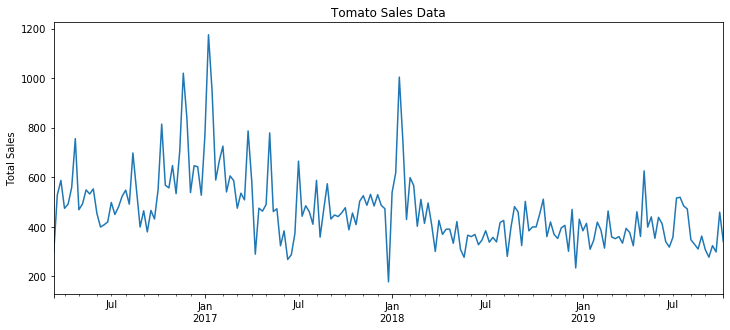

In [172]:
title='Tomato Sales Data'
ylabel='Total Sales'
xlabel='' 

ax = df['TOTAL_PRICESELL'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

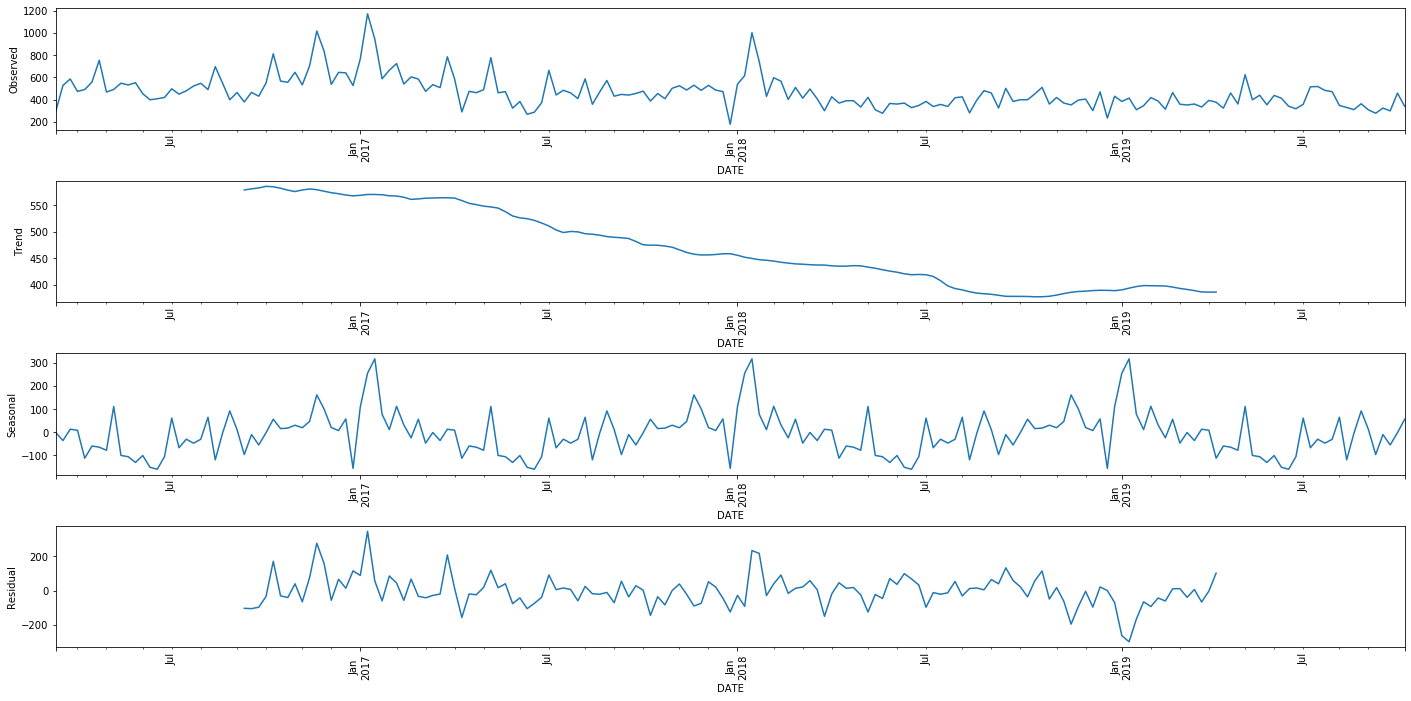

In [173]:
result = seasonal_decompose(df['TOTAL_PRICESELL'], model='add')

observed = result.observed
trend = result.trend
seasonal =  result.seasonal
residual =  result.resid

decomp_data = pd.DataFrame({"Observed":observed, "Trend": trend, "Seasonal":seasonal,"Residual":residual})

import matplotlib.pyplot as plt

figure, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10))
figure.tight_layout(pad=3.0)
for i, ax in enumerate(axes):
    ax = decomp_data.iloc[:,i].plot(ax=ax)
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)
#     ax.xaxis.set_minor_locator(months)
#     ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(decomp_data.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

figure.savefig('tomato_decomp.png')

In [174]:
#auto_arima(df['TOTAL_PRICESELL'],seasonal=True,m=52).summary()

In [175]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [176]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -841.232
Date:                            Sun, 17 May 2020   AIC                           1690.463
Time:                                    11:39:00   BIC                           1702.055
Sample:                                03-14-2016   HQIC                          1695.174
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7516      0.052    -14.467      0.000      -0.853      -0.650
ar.S.L52      -0.5599      1.836     -0.305      0.760      -4.159       3.039
ma.S.L52       0.9883     42.453      0.023      0.981     -82.217      84.194
sigma2      1.351e+04   5.49e+05      0.025      0.980   -1.06e+06    1.09e+06
===================================================================================
Ljung-Box (Q):                       53.63   Jarque-Bera (JB):                72.29
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             1.04
Prob(H) (two-sided):                  0.08   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [177]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

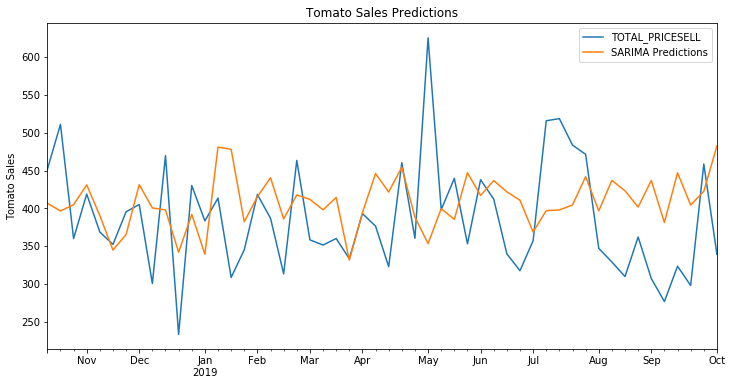

In [178]:
#Compare to validation data
title='Tomato Sales Predictions'
ylabel='Tomato Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [179]:
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMA MSE: {error1:11.10}')
print(f'SARIMA RMSE: {error2:11.10}')

SARIMA MSE: 6926.028211
SARIMA RMSE: 83.22276258


In [180]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA Forecast')

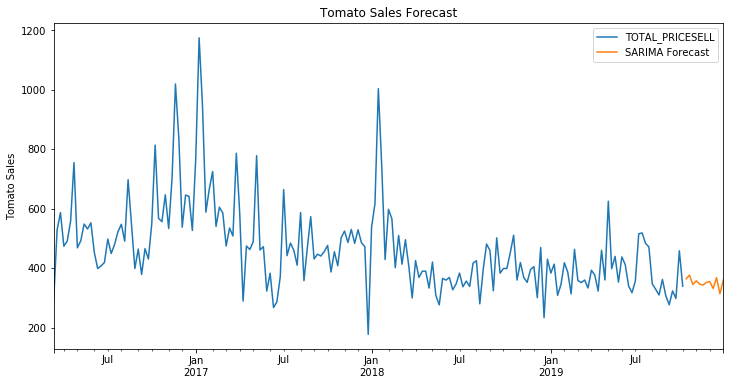

In [181]:
title='Tomato Sales Forecast'
ylabel='Tomato Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [182]:
train = df.iloc[:len(df)-52]
test = df.iloc[len(df)-52:]

In [183]:
train.head()

,TOTAL_PRICESELL,holidayWeekS
DATE,,
2016-03-14,292.85886,0
2016-03-21,528.13998,39
2016-03-28,586.91094,0
2016-04-04,474.18022,0
2016-04-11,491.09386,0


In [184]:
#Train on training data set
model = SARIMAX(train['TOTAL_PRICESELL'],exog=train['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    TOTAL_PRICESELL   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -839.412
Date:                            Sun, 17 May 2020   AIC                           1688.824
Time:                                    11:39:20   BIC                           1703.313
Sample:                                03-14-2016   HQIC                          1694.712
                                     - 10-08-2018                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
holidayWeekS    -2.7303      1.046     -2.609      0.009      -4.781      -0.679
ma.L1           -0.7163      0.055    -12.933      0.000      -0.825      -0.608
ar.S.L52        -0.5716      2.033     -0.281      0.779      -4.557       3.414
ma.S.L52         0.9928     72.753      0.014      0.989    -141.601     143.587
sigma2        1.318e+04   9.32e+05      0.014      0.989   -1.81e+06    1.84e+06
===================================================================================
Ljung-Box (Q):                       46.22   Jarque-Bera (JB):                68.70
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             1.08
Prob(H) (two-sided):                  0.18   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [185]:
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holidayWeekS']] 
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')
error1 = mean_squared_error(test['TOTAL_PRICESELL'], predictions)
error2 = rmse(test['TOTAL_PRICESELL'], predictions)
print(f'SARIMAX MSE: {error1:11.10}')
print(f'SARIMAX RMSE: {error2:11.10}')

SARIMAX MSE: 6572.673988
SARIMAX RMSE: 81.07202963


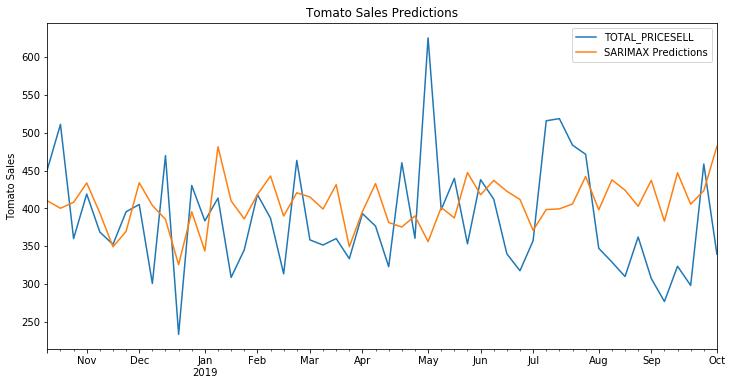

In [186]:
#Compare to validation data
title='Tomato Sales Predictions'
ylabel='Tomato Sales'
xlabel=''

ax = test['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [187]:
#Retrain on full data set and make a forecast for 12 weeks out
model = SARIMAX(df['TOTAL_PRICESELL'],exog=df['holidayWeekS'],order=(0,1,1),seasonal_order=(1,0,1,52))
results = model.fit()

In [188]:
start=len(df)
end=len(df) + 11
exog_forecast = pd.read_csv(r'C:\Users\ashbat\Desktop\ExogHolidays.csv',index_col='DATE',parse_dates=True)
exog_forecast.index.freq = 'W-MON'
exog_forecast = exog_forecast[['holidayWeekS']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')

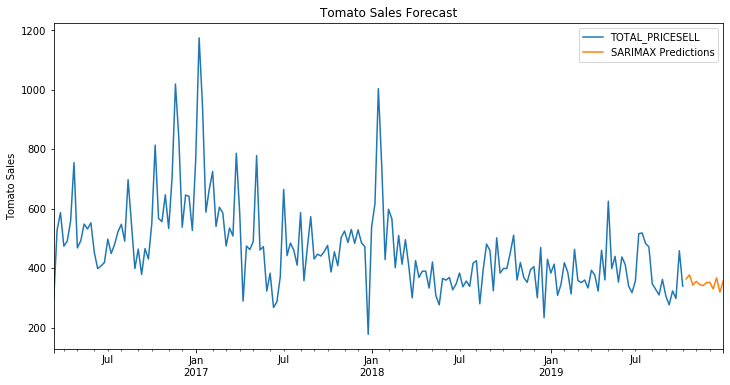

In [190]:
title='Tomato Sales Forecast'
ylabel='Tomato Sales'
xlabel=''

ax = df['TOTAL_PRICESELL'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);